In [1]:
!pip install gdown

In [2]:
!gdown 1OZoqCUo48iXDPfD71uq0olbzkdnixvrE

Downloading...
From (original): https://drive.google.com/uc?id=1OZoqCUo48iXDPfD71uq0olbzkdnixvrE
From (redirected): https://drive.google.com/uc?id=1OZoqCUo48iXDPfD71uq0olbzkdnixvrE&confirm=t&uuid=c9c8db29-00b8-4254-baf3-f639cca0625c
To: /content/LibriSpeech_WAV.zip
100% 10.5G/10.5G [02:19<00:00, 74.8MB/s]


In [3]:
!unzip LibriSpeech_WAV.zip

Streaming output truncated to the last 5000 lines.
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0008.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0029.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0003.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0019.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0000.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0012.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0020.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0014.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0011.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0022.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0028.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0006.wav  
  inflating: LibriSpeech_WAV/train-cl

In [4]:
!pip install librosa matplotlib pandas numpy scipy tqdm soundfile

# Libraries

In [5]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.fft import fft
from tqdm import tqdm

# EDA

## Train-Clean Data

In [6]:
# load all .wav paths from LibriSpeech

DATASET_PATH_1 = "LibriSpeech_WAV/train-clean"

wav_files_train = []
for root, _, files in os.walk(DATASET_PATH_1):
    for f in files:
        if f.endswith(".wav"):
            wav_files_train.append(os.path.join(root, f))

print("Total wav files:", len(wav_files_train))

Total wav files: 28539


In [7]:
# Basic Metadata EDA (sample rate, duration, size)
metadata = []

for path in tqdm(wav_files_train[:1000]):
    y, sr = librosa.load(path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    size_kb = os.path.getsize(path) / 1024

    metadata.append([path, sr, duration, size_kb])

df = pd.DataFrame(metadata, columns=["path", "sample_rate", "duration_sec", "size_kb"])
df.head(10)

100%|██████████| 1000/1000 [00:24<00:00, 41.55it/s]


,path,sample_rate,duration_sec,size_kb
0,LibriSpeech_WAV/train-clean/2843/152918/2843-1...,16000,9.420,294.417969
1,LibriSpeech_WAV/train-clean/2843/152918/2843-1...,16000,15.155,473.636719
2,LibriSpeech_WAV/train-clean/2843/152918/2843-1...,16000,4.625,144.574219
3,LibriSpeech_WAV/train-clean/2843/152918/2843-1...,16000,15.655,489.261719
4,LibriSpeech_WAV/train-clean/2843/152918/2843-1...,16000,15.885,496.449219
5,LibriSpeech_WAV/train-clean/2843/152918/2843-1...,16000,14.255,445.511719
6,LibriSpeech_WAV/train-clean/2843/152918/2843-1...,16000,13.445,420.199219
7,LibriSpeech_WAV/train-clean/2843/152918/2843-1...,16000,14.390,449.730469
8,LibriSpeech_WAV/train-clean/2843/152918/2843-1...,16000,14.680,458.792969
9,LibriSpeech_WAV/train-clean/2843/152918/2843-1...,16000,15.840,495.042969


- The sample rate is uniformly 16000 Hz, which is the standard for speech recognition task. This indicates that resampling is likely not needed for preprocessing.
- The duration varies, which means data loader will need to handle variable-length sequences, likely via padding (to the longest batch length) or masking.
- File size strictly correlates with duration

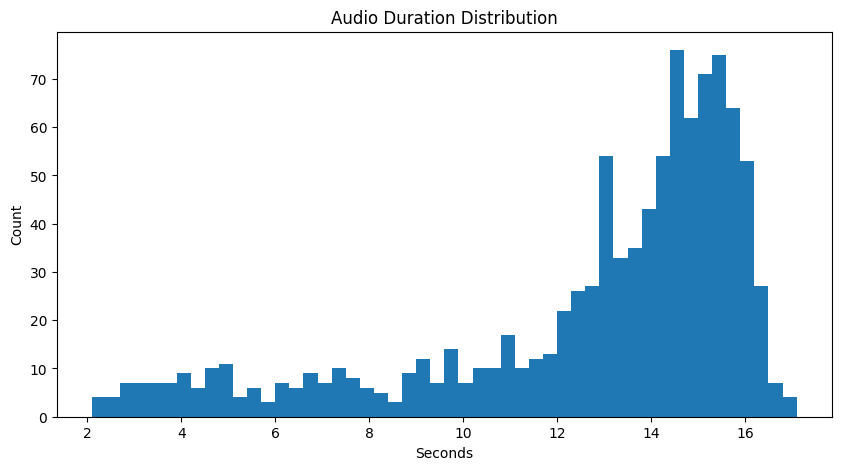

In [8]:
# Check duration distribution

plt.figure(figsize=(10,5))
plt.hist(df["duration_sec"], bins=50)
plt.title("Audio Duration Distribution")
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.show()

- Minimum duration seems to be no shorter than 2 seconds. This seems good, as extremely short clips often contain only silence or cut-off words, which can destabilize training.
- Maximum duration seems to be capped around 17 seconds. This "hard stop" suggests the dataset was pre-segmented to avoid extremely long utterances.
- The audio distribution is left skewed with a heavy concentration of files between 12 to 16 seconds
- Since most files are between 12-16s, setting a fixed input size for our model slightly lower (e.g., 10s), would be truncating a massive portion of your data. Conversely, padding everything to 20s is safe but might be computationally wasteful for the few short clips. Bucketing (grouping similar lengths) might be the best training strategy here.

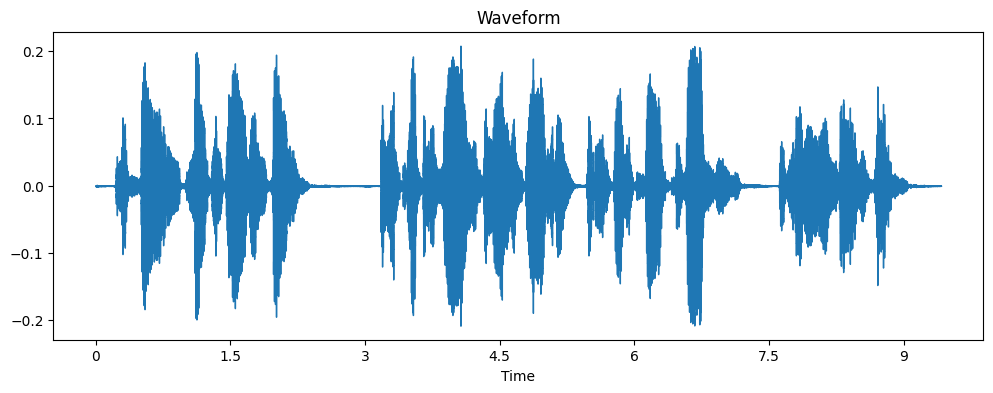

In [9]:
# Waveform Visualization (time domain)

sample_path = wav_files_train[0]
y, sr = librosa.load(sample_path, sr=None)

plt.figure(figsize=(12,4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.show()

- In the silence regions (start, end, and between words), the amplitude line is very thin and close to zero. This confirms the dataset is indeed "clean" speech with very little background noise. It has good Signal-To-Noise Ratio (SNR)
- The "blobs" of high amplitude represent words or phrases. There are distinct gaps between them, indicating clear sentence structures.
- The amplitude peaks reach roughly +/- 0.2. The audio is not "clipped" (hitting the +/- 1.0 maximum), which means the audio fidelity is preserved and no information is lost to distortion.

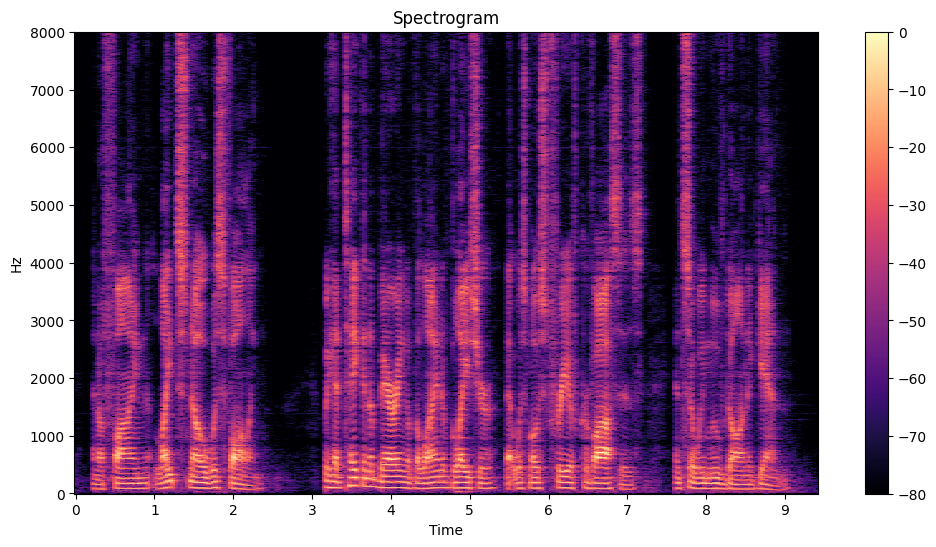

In [10]:
# Short-Time Fourier Transform (STFT) Spectogram
# To visualize signal frequency changes over time

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.figure(figsize=(12,6))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram")
plt.show()

- The y-axis goes up to 8000 Hz. This is mathematically consistent with the 16 kHz sample rate (Nyquist frequency = Sample Rate / 2).
- Most of the energy (bright orange/yellow) is concentrated between 0 and 4000 Hz. This is typical for human speech.
- The horizontal "striations" in the lower frequencies, represent the harmonics of the speaker's vocal cords (voiced speech).
- The shifting bright bands represent formants, which are critical for distinguishing vowel sounds.
- The deep purple/black background confirms the high SNR observed in the waveform. There is almost no constant background hum or static.

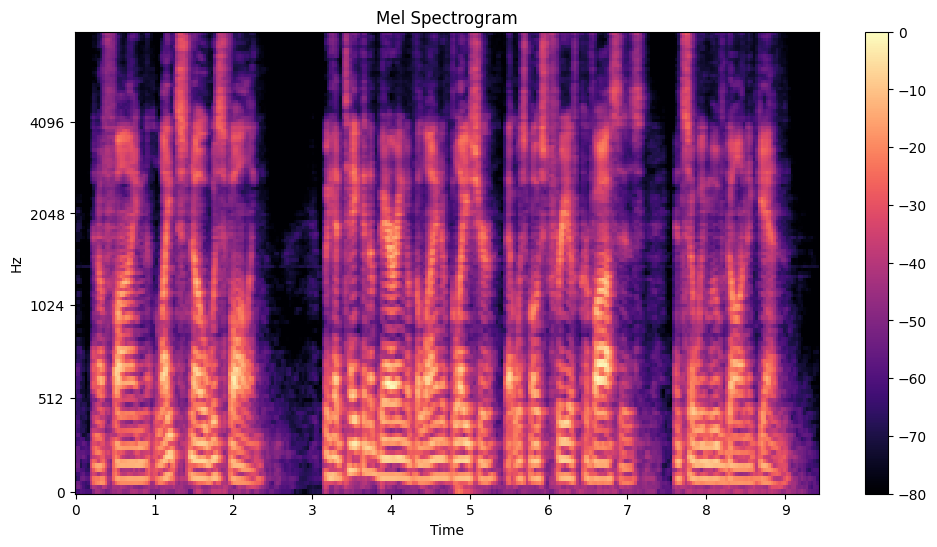

In [11]:
# Mel Spectogram (converts to decibels)

mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_db = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(12,6))
librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()

- Unlike the previous STFT spectrogram (which has a linear y-axis), this y-axis is compressed. The lower frequencies (where human speech content resides) are expanded, while higher frequencies are compressed.
- Information Density: The bright vertical bands (formants) are much clearer here than in the raw spectrogram. This representation matches how the human ear resolves frequencies, making it a superior input feature for Deep Learning models (like CNNs or Transformers) compared to a raw STFT.

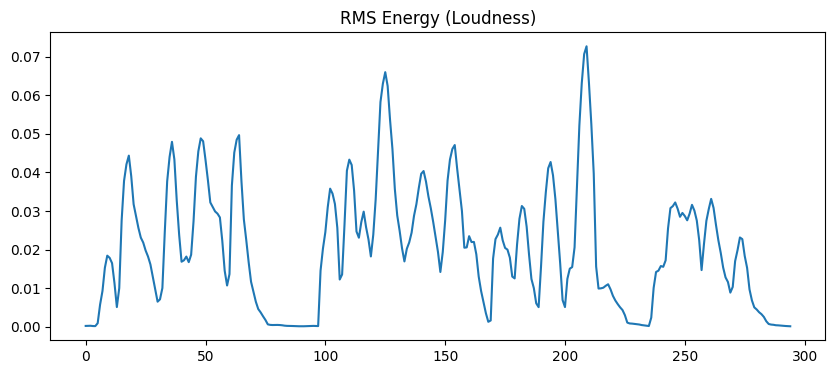

In [12]:
# Amplitude / Loudness (RMS)

rms = librosa.feature.rms(y=y)[0]

plt.figure(figsize=(10,4))
plt.plot(rms)
plt.title("RMS Energy (Loudness)")
plt.show()

- The plot clearly shows high energy peaks (active speech) and near-zero valleys (silence).
- The peaks vary in height, indicating natural speech dynamics (some words are stressed/louder than others).
- This feature is excellent for segmenting audio. We could use a simple threshold on this graph to automatically crop silence from the start/end of clips, reducing the data size without losing information.

100%|██████████| 200/200 [00:00<00:00, 668.53it/s]


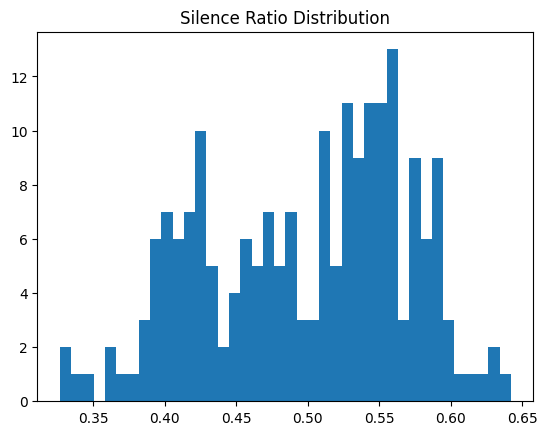

In [13]:
# Silence ratio

def silence_ratio(y, threshold=0.01):
    """
    Input: y is the audio waveform array, threshold defines what amplitude is treated as silence.
    Process: Counts how many samples in y have absolute amplitude below the threshold.
    Output: Returns the proportion of silent samples (0–1) in the audio signal.
    """
    silent = np.sum(np.abs(y) < threshold)
    return silent / len(y)

ratios_train = []
for path in tqdm(wav_files_train[:200]):
    y, sr = librosa.load(path, sr=None)
    ratios_train.append(silence_ratio(y))

plt.hist(ratios_train, bins=40)
plt.title("Silence Ratio Distribution")
plt.show()

- The distribution is centered around 0.55 (55%). This means that in a typical training file, more than half the data is silence.
- This is common in the LibriSpeech dataset, which contains full sentence utterances. The silence includes pauses between words, grammatical pauses, and head/tail silence.
- Since training a model on 55% silence is inefficient. Maybe we can consider trimming (removing start/end silence) or filtering (dropping files that are >80% silence (the far right of the histogram), as they might be bad data).

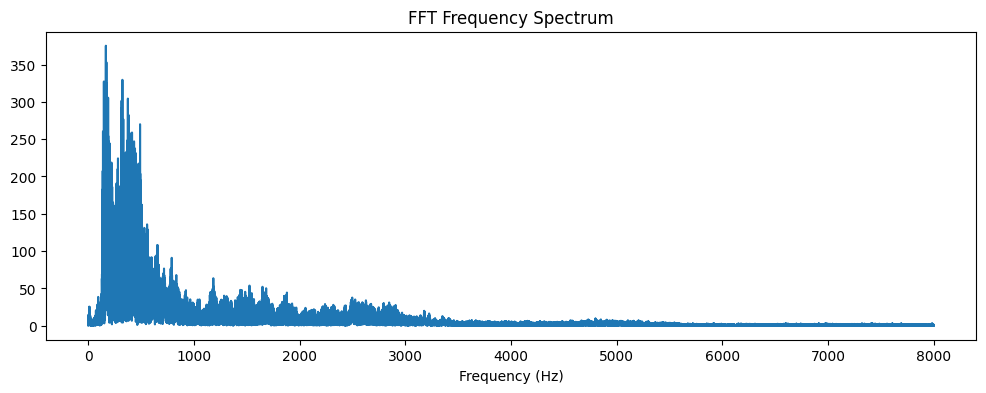

In [14]:
# Fast Fourier Transform (FFT) Frequency Analysis

Y = np.abs(fft(y))
freqs = np.linspace(0, sr, len(Y))

plt.figure(figsize=(12,4))
plt.plot(freqs[:len(freqs)//2], Y[:len(Y)//2])
plt.title("FFT Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.show()

- There is a massive spike in energy between 100 Hz and 500 Hz. This corresponds to the fundamental frequency of the human voice (typically 85-255 Hz) and the first few harmonics.
- The energy drops off significantly after 1000 Hz and flattens out by 4000 Hz. This confirms the audio is focused on speech frequencies and doesn't contain significant high-frequency noise or music.

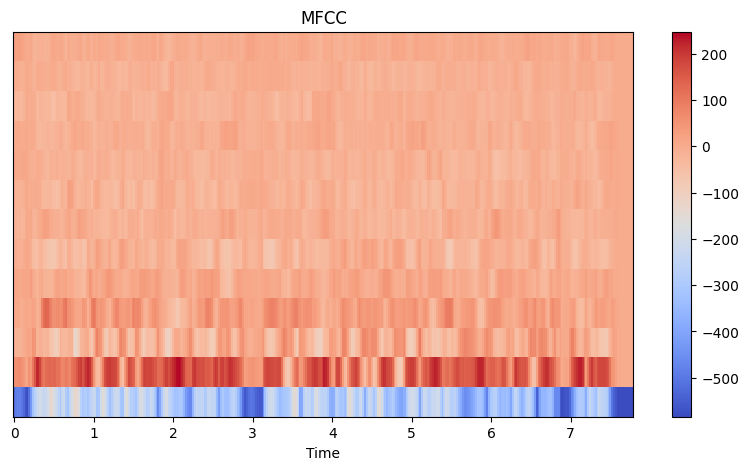

In [15]:
# MFCC Visualization

mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(10,5))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title("MFCC")
plt.show()

- Unlike the spectrogram, where adjacent rows are highly correlated (smooth transitions), MFCC rows are more independent.
- Coefficient 0 (Bottom Blue/Red Band): The bottom row (0th coefficient) represents the total energy of the frame. It acts almost exactly like the RMS plot.
- Coefficients 1-12 (Red/Peach): These encode the shape of the vocal tract (phonemes). The fact that we can see distinct vertical patterns here means the MFCCs are successfully capturing the "texture" of the spoken words.
- While modern End-to-End Deep Learning models often prefer Mel Spectrograms, MFCCs are still the industry standard for simpler models or when computational resources are extremely limited.

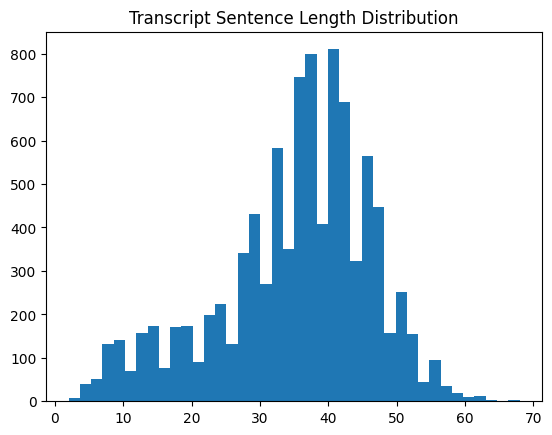

In [16]:
# Transcript EDA (text analysis : counts the number of words per sentence.)

text_files = []
for root, _, files in os.walk(DATASET_PATH_1):
    for f in files:
        if f.endswith(".txt"):
            text_files.append(os.path.join(root, f))

sent_lengths = []

for file in text_files[:200]:
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            text = " ".join(line.strip().split()[1:])
            sent_lengths.append(len(text.split()))

plt.hist(sent_lengths, bins=40)
plt.title("Transcript Sentence Length Distribution")
plt.show()

- The sentence lengths are approximately normally distributed, with a slight right skew.
- The mode (highest bar) is around 35-40 words.
- Most sentences fall between 10 and 55 words.
- There are very few sentences longer than 60 words.
- We should probably set our model's max_text_length to around 100 tokens. This will safely cover >99% of our data without excessive padding, optimizing memory usage.

In [17]:
# Speaker Distribution (counts the number of audio files per speaker)

speakers = [path.split(os.sep)[-3] for path in wav_files_train]
speaker_counts = pd.Series(speakers).value_counts()

speaker_counts.head(10)

,count
211,166
4014,165
730,161
8063,155
2989,155
4195,140
125,138
27,138
1867,137
118,137


- The top speakers (IDs 211, 4014, 730) all have roughly similar counts (~160 files).
- The counts decrease slowly (166 down to 137 for the 10th speaker).
- The dataset is well-balanced. There is no "super-speaker" dominating the dataset, which prevents the model from overfitting to one specific voice or accent. Means that it is usable to create a generalized ASR system that recognizes phoneme.

## Dev-Clean Data

In [18]:
# load dev-clean data

DATASET_PATH_2 = "LibriSpeech_WAV/dev-clean"

wav_files_dev = []
for root, _, files in os.walk(DATASET_PATH_2):
    for f in files:
        if f.endswith(".wav"):
            wav_files_dev.append(os.path.join(root, f))

print("Total wav files:", len(wav_files_dev))

Total wav files: 2703


- This is roughly ~9.5% of the training set size (28539 files). This is a perfect ratio for a validation set (as typically 10-20% is recommended)

In [19]:
# Basic Metadata EDA (sample rate, duration, size)
metadata = []

for path in tqdm(wav_files_dev[:500]):
    y, sr = librosa.load(path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    size_kb = os.path.getsize(path) / 1024

    metadata.append([path, sr, duration, size_kb])

df = pd.DataFrame(metadata, columns=["path", "sample_rate", "duration_sec", "size_kb"])
df.head(10)

100%|██████████| 500/500 [00:01<00:00, 411.91it/s]


,path,sample_rate,duration_sec,size_kb
0,LibriSpeech_WAV/dev-clean/7850/281318/7850-281...,16000,3.850000,120.355469
1,LibriSpeech_WAV/dev-clean/7850/281318/7850-281...,16000,5.210000,162.855469
2,LibriSpeech_WAV/dev-clean/7850/281318/7850-281...,16000,4.275000,133.636719
3,LibriSpeech_WAV/dev-clean/7850/281318/7850-281...,16000,7.965000,248.949219
4,LibriSpeech_WAV/dev-clean/7850/281318/7850-281...,16000,4.335000,135.511719
5,LibriSpeech_WAV/dev-clean/7850/281318/7850-281...,16000,4.175000,130.511719
6,LibriSpeech_WAV/dev-clean/7850/281318/7850-281...,16000,7.865062,245.826172
7,LibriSpeech_WAV/dev-clean/7850/281318/7850-281...,16000,3.205000,100.199219
8,LibriSpeech_WAV/dev-clean/7850/281318/7850-281...,16000,4.310000,134.730469
9,LibriSpeech_WAV/dev-clean/7850/281318/7850-281...,16000,7.540000,235.667969


- The sample rate is uniformly 16000 Hz same as the training data, so no resampling needed.
- The duration seems to contain shorter files, we'll check using duration distribution

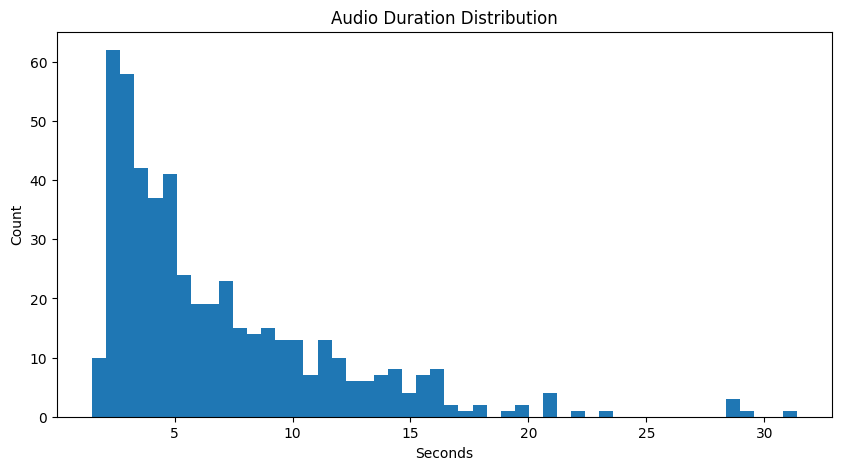

In [20]:
# Check duration distribution

plt.figure(figsize=(10,5))
plt.hist(df["duration_sec"], bins=50)
plt.title("Audio Duration Distribution")
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.show()

- Unlike the training set (which was mostly 12-16s), the Dev set is right skewed and dominated by short clips. The peak is at 2-4 seconds. This implies the Dev set contains short sentences or brief phrases, whereas the Training set consists of full, long sentences.
- The x-axis extends to 35 seconds. There are visible outliers around 25s, 30s, and 35s. Meanwhile our training data had a hard "cap" at ~17 seconds.
- This means we can't design our model architecture or data loader to handle a maximum of 20 seconds (based on training data)

100%|██████████| 200/200 [00:00<00:00, 1109.46it/s]


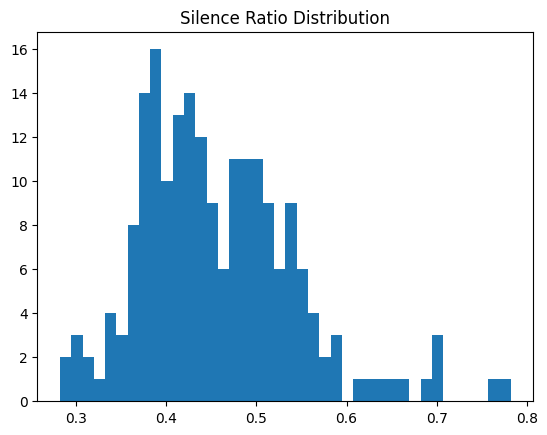

In [21]:
# Silence ratio

ratios_dev = []
for path in tqdm(wav_files_dev[:200]):
    y, sr = librosa.load(path, sr=None)
    ratios_dev.append(silence_ratio(y))

plt.hist(ratios_dev, bins=40)
plt.title("Silence Ratio Distribution")
plt.show()

- There is a shift in the silence ration distribution, the train set peaked around 0.55 (55%) silence, but the dev set peaks around 0.4 (40%) silence.
- The Dev data is "denser." It has less silence padding than the training data.
- This means our validation metrics will purely reflect how well the model transcribes speech, rather than how well it predicts "silence" tokens.

## Test-Clean Data

In [22]:
# load test-clean data

DATASET_PATH_3 = "LibriSpeech_WAV/test-clean"

wav_files_test = []
for root, _, files in os.walk(DATASET_PATH_3):
    for f in files:
        if f.endswith(".wav"):
            wav_files_test.append(os.path.join(root, f))

print("Total wav files:", len(wav_files_test))

Total wav files: 2620


- The dataset size is almost identical in size to the Dev set (2703 files). This symmetry is intentional in standard datasets to ensure validation and testing are statistically comparable.

In [23]:
# Basic Metadata EDA (sample rate, duration, size)
metadata = []

for path in tqdm(wav_files_test[:500]):
    y, sr = librosa.load(path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    size_kb = os.path.getsize(path) / 1024

    metadata.append([path, sr, duration, size_kb])

df = pd.DataFrame(metadata, columns=["path", "sample_rate", "duration_sec", "size_kb"])
df.head(10)

100%|██████████| 500/500 [00:00<00:00, 1042.90it/s]


,path,sample_rate,duration_sec,size_kb
0,LibriSpeech_WAV/test-clean/8455/210777/8455-21...,16000,15.065,470.824219
1,LibriSpeech_WAV/test-clean/8455/210777/8455-21...,16000,7.560,236.292969
2,LibriSpeech_WAV/test-clean/8455/210777/8455-21...,16000,11.285,352.699219
3,LibriSpeech_WAV/test-clean/8455/210777/8455-21...,16000,10.810,337.855469
4,LibriSpeech_WAV/test-clean/8455/210777/8455-21...,16000,12.625,394.574219
5,LibriSpeech_WAV/test-clean/8455/210777/8455-21...,16000,4.110,128.480469
6,LibriSpeech_WAV/test-clean/8455/210777/8455-21...,16000,7.840,245.042969
7,LibriSpeech_WAV/test-clean/8455/210777/8455-21...,16000,3.000,93.792969
8,LibriSpeech_WAV/test-clean/8455/210777/8455-21...,16000,2.260,70.667969
9,LibriSpeech_WAV/test-clean/8455/210777/8455-21...,16000,8.105,253.324219


- The sample rate 16000 Hz is consistent in train, dev, and test dataset.
- The duration seems to vary more than dev set

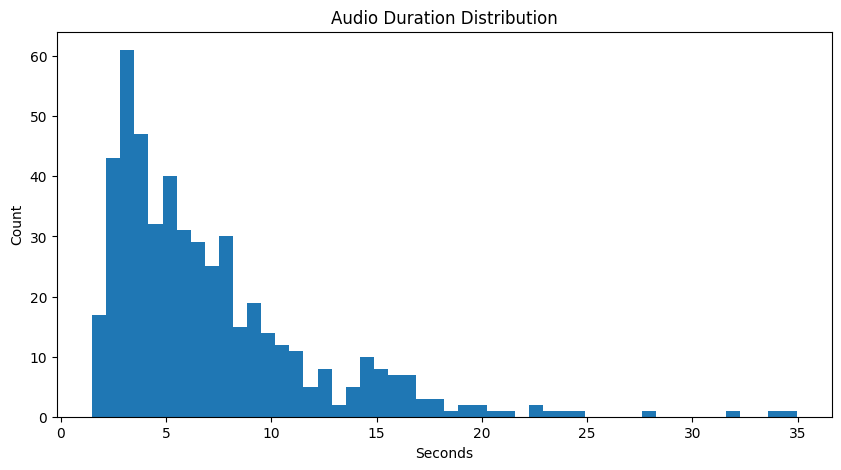

In [24]:
# Check duration distribution

plt.figure(figsize=(10,5))
plt.hist(df["duration_sec"], bins=50)
plt.title("Audio Duration Distribution")
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.show()

- The test set duration distribution is right skewed, with the highest bar at ~3 seconds
- The x-axis extends all the way to 35 seconds, similar to the dev set

100%|██████████| 200/200 [00:00<00:00, 911.69it/s]


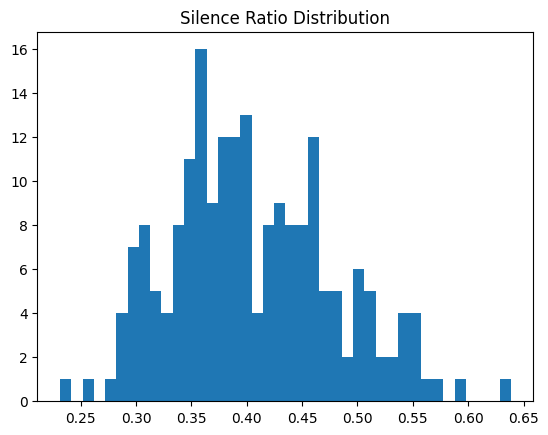

In [25]:
# Silence ratio

ratios_test = []
for path in tqdm(wav_files_test[:200]):
    y, sr = librosa.load(path, sr=None)
    ratios_test.append(silence_ratio(y))

plt.hist(ratios_test, bins=40)
plt.title("Silence Ratio Distribution")
plt.show()

- The curve is centered around 0.35 - 0.45 (35-45%), similar to dev set.
- Which means the test data is denser and contains more actual speech per second.
- There is a small cluster of files on the far right (>0.60 silence). These are likely short files with long leading/trailing pauses.

In [26]:
# Check if there is any data leakage, whether each set is independent with no same speaker

def get_speakers(file_list):
    """
    Input is a list of file paths from librispeech
    Process is to extract speaker IDs from the file paths
    Output is a set of speaker IDs
    """
    speakers = set()
    for file_path in file_list:
        if isinstance(file_path, str):
            parts = file_path.split(os.sep)
            speaker_id = parts[-3]
            speakers.add(speaker_id)
    return speakers

train_spk = get_speakers(wav_files_train)
dev_spk = get_speakers(wav_files_dev)
test_spk = get_speakers(wav_files_test)

leakage_train_dev = train_spk.intersection(dev_spk)
leakage_train_test = train_spk.intersection(test_spk)
leakage_dev_test = dev_spk.intersection(test_spk)

print(f"--- Speaker Counts ---")
print(f"Train Speakers: {len(train_spk)}")
print(f"Dev Speakers:   {len(dev_spk)}")
print(f"Test Speakers:  {len(test_spk)}")

print(f"\n--- Leakage Report ---")

if len(leakage_train_dev) > 0:
    print(f"[FAIL] Train-Dev Leakage detected! ({len(leakage_train_dev)} speakers)")
    print(f"Speakers: {leakage_train_dev}")
else:
    print("[PASS] Train vs Dev: Independent.")

if len(leakage_train_test) > 0:
    print(f"[FAIL] Train-Test Leakage detected! ({len(leakage_train_test)} speakers)")
    print(f"Speakers: {leakage_train_test}")
else:
    print("[PASS] Train vs Test: Independent.")

if len(leakage_dev_test) > 0:
    print(f"[WARN] Dev-Test Overlap detected! ({len(leakage_dev_test)} speakers)")
    print(f"Note: It is rare but acceptable for Dev and Test to share speakers, but generally they should be disjoint.")
else:
    print("[PASS] Dev vs Test:   Independent.")

--- Speaker Counts ---
Train Speakers: 251
Dev Speakers:   40
Test Speakers:  40

--- Leakage Report ---
[PASS] Train vs Dev: Independent.
[PASS] Train vs Test: Independent.
[PASS] Dev vs Test:   Independent.


- There is no data leakage between all split sets